In [3]:
import pandas as pd
import numpy as np
import itertools

#Graphs
import matplotlib
from matplotlib import pyplot
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
matplotlib.rcParams['text.color'] = 'k'

#Normalisation
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

#Model libraries
import statsmodels.api as sm
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic

import warnings
warnings.filterwarnings("ignore")
from math import sqrt

In [4]:
# from google.colab import drive
# drive.mount('/content/drive')

Reading Dataset into a Pandas DataFrame

In [18]:
#df=pd.read_csv('/content/drive/MyDrive/Data Analytics Project - Supply Chain Analysis/Dataset/DataCoSupplyChainDataset.csv',encoding='unicode_escape')
data=pd.read_csv('Dataset/Cleaned_data.csv',encoding='unicode_escape')

Dataset preprocessing - dropping unused features and removing null values

In [19]:
#data=df.drop(columns=['Order Zipcode', 'Product Description','Customer Email','Customer Password','Customer Street','Latitude','Longitude','Order Id','Order Item Cardprod Id','Order Zipcode','Product Description','Product Image'])

In [20]:
data = data.dropna()
len(data)

180519

In [21]:
data.isnull().sum()


Order_Date                       0
Order Item Quantity              0
Department Id                    0
Product Category Id              0
Order Customer Id                0
Product Card Id                  0
Days for shipment (scheduled)    0
Order Item Profit Ratio          0
Sales                            0
Order Item Discount Rate         0
Order Item Product Price         0
dtype: int64

In [23]:
#data=data.rename(columns = {'order date (DateOrders)': 'Order_Date'}, inplace = False)
unnorm=data[data.columns]
unnorm.columns

Index(['Order_Date', 'Order Item Quantity', 'Department Id',
       'Product Category Id', 'Order Customer Id', 'Product Card Id',
       'Days for shipment (scheduled)', 'Order Item Profit Ratio', 'Sales',
       'Order Item Discount Rate', 'Order Item Product Price'],
      dtype='object')

In [10]:
data.head()
numerical_features = [f for f in data.columns if data[f].dtypes!='O']
only=data[numerical_features]
col=['Late_delivery_risk', 'Category Id', 'Customer Id', 'Customer Zipcode', 'Department Id', 'Order Customer Id',  'Product Card Id', 'Product Category Id', 'Product Status']
only=only.drop(columns=col)
only.head()
only_features = [f for f in only.columns ]
values = only.values
values = values.reshape((len(values), len(only.columns)))

# train the standardization
scaler = StandardScaler()
scaler = scaler.fit(values)

# # standardization of the dataset and printing the first 5 rows
normalized = scaler.transform(values)
# for i in range(5):
# 	print(normalized[i])

# # inverse transform and print the first 5 rows
# inversed = scaler.inverse_transform(normalized)
# for i in range(5):
# 	print(inversed[i])

data.drop(labels=only.columns, axis="columns", inplace=True)
data[only.columns] = only[only.columns]
data.head()

,Type,Delivery Status,Late_delivery_risk,Category Id,Category Name,Customer City,Customer Country,Customer Fname,Customer Id,Customer Lname,...,Order Item Discount,Order Item Discount Rate,Order Item Id,Order Item Product Price,Order Item Profit Ratio,Order Item Quantity,Sales,Order Item Total,Order Profit Per Order,Product Price
0,DEBIT,Advance shipping,0,73,Sporting Goods,Caguas,Puerto Rico,Cally,20755,Holloway,...,13.110000,0.04,180517,327.75,0.29,1,327.75,314.640015,91.250000,327.75
1,TRANSFER,Late delivery,1,73,Sporting Goods,Caguas,Puerto Rico,Irene,19492,Luna,...,16.389999,0.05,179254,327.75,-0.80,1,327.75,311.359985,-249.089996,327.75
2,CASH,Shipping on time,0,73,Sporting Goods,San Jose,EE. UU.,Gillian,19491,Maldonado,...,18.030001,0.06,179253,327.75,-0.80,1,327.75,309.720001,-247.779999,327.75
3,DEBIT,Advance shipping,0,73,Sporting Goods,Los Angeles,EE. UU.,Tana,19490,Tate,...,22.940001,0.07,179252,327.75,0.08,1,327.75,304.809998,22.860001,327.75
4,PAYMENT,Advance shipping,0,73,Sporting Goods,Caguas,Puerto Rico,Orli,19489,Hendricks,...,29.500000,0.09,179251,327.75,0.45,1,327.75,298.250000,134.210007,327.75


In [24]:
data.isnull().sum()
data = data.dropna()
data.shape

(180519, 11)

In [55]:
#data=data.set_index('Order_Date')
#data.index.name = 'Order_Date'

In [25]:
unnorm.columns

Index(['Order_Date', 'Order Item Quantity', 'Department Id',
       'Product Category Id', 'Order Customer Id', 'Product Card Id',
       'Days for shipment (scheduled)', 'Order Item Profit Ratio', 'Sales',
       'Order Item Discount Rate', 'Order Item Product Price'],
      dtype='object')

In [26]:
def correlation(dataset, threshold):
    col_corr = set() # Set of all the names of deleted columns
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if (corr_matrix.iloc[i, j] >= threshold) and (corr_matrix.columns[j] not in col_corr):
                colname = corr_matrix.columns[i] # getting the name of column
                col_corr.add(colname)
               # deleting the column from the dataset

        #print(corr_matrix.columns[i],"           ",col_corr)
    print(col_corr)
correlation(data,0.5)

{'Order Item Product Price', 'Product Category Id', 'Product Card Id'}


In [27]:
#Select the department Id from [2,3,4,5,7]
unnorm=unnorm.loc[unnorm['Department Id'] == 2]
new=data.loc[data['Department Id'] == 2]

#Indexing this dataset by date
new=new.set_index('Order_Date')
unnorm=unnorm.set_index('Order_Date')

new=new[['Product Category Id', 'Order Customer Id',  'Days for shipment (scheduled)', 'Order Item Profit Ratio', 'Product Card Id', 'Sales', 'Order Item Discount Rate', 'Order Item Product Price']]
unnorm=unnorm[['Product Category Id', 'Order Customer Id',  'Days for shipment (scheduled)', 'Order Item Profit Ratio', 'Product Card Id', 'Sales', 'Order Item Discount Rate', 'Order Item Product Price']]

#print(type(new.index),new.index)
new.index = pd.DatetimeIndex(new.index).to_period('D')
unnorm.index = pd.DatetimeIndex(unnorm.index).to_period('D')

#print(type(new.index),new.index)
new.sort_index(inplace=True)
unnorm.sort_index(inplace=True)
unnorm.head()

,Product Category Id,Order Customer Id,Days for shipment (scheduled),Order Item Profit Ratio,Product Card Id,Sales,Order Item Discount Rate,Order Item Product Price
Order_Date,,,,,,,,
2015-01-01,5,2667,0.777152,-0.279881,93,-0.973762,2.106536,-0.831896
2015-01-01,3,2711,-1.405546,-0.001385,37,-1.011487,1.396461,-0.760330
2015-01-01,7,1837,0.777152,0.319955,134,-0.784531,0.402355,-0.831824
2015-01-02,5,10072,0.777152,0.298533,93,-0.595906,1.396461,-0.831896
2015-01-02,7,58,0.777152,0.341378,135,-1.041576,2.106536,-0.853294


In [28]:
new.head()


,Product Category Id,Order Customer Id,Days for shipment (scheduled),Order Item Profit Ratio,Product Card Id,Sales,Order Item Discount Rate,Order Item Product Price
Order_Date,,,,,,,,
2015-01-01,5,2667,0.777152,-0.279881,93,-0.973762,2.106536,-0.831896
2015-01-01,3,2711,-1.405546,-0.001385,37,-1.011487,1.396461,-0.760330
2015-01-01,7,1837,0.777152,0.319955,134,-0.784531,0.402355,-0.831824
2015-01-02,5,10072,0.777152,0.298533,93,-0.595906,1.396461,-0.831896
2015-01-02,7,58,0.777152,0.341378,135,-1.041576,2.106536,-0.853294


In [29]:
len(data)

180519

In [30]:
data.isnull().sum()

Order_Date                       0
Order Item Quantity              0
Department Id                    0
Product Category Id              0
Order Customer Id                0
Product Card Id                  0
Days for shipment (scheduled)    0
Order Item Profit Ratio          0
Sales                            0
Order Item Discount Rate         0
Order Item Product Price         0
dtype: int64

In [33]:
#nobs =int(len(new)*0.5)
nobs=len(new)
print(len(new))

#Initialise test and train datasets
df_train, df_test = new,new
df_test.sort_index(inplace=True)
df_train.sort_index(inplace=True)

# Check shape
print(df_train.shape) 
print(df_test.shape)
print(df_train.index)

2479
(2479, 8)
(2479, 8)
PeriodIndex(['2015-01-01', '2015-01-01', '2015-01-01', '2015-01-02',
             '2015-01-02', '2015-01-02', '2015-01-03', '2015-01-03',
             '2015-01-04', '2015-01-04',
             ...
             '2018-01-13', '2018-01-13', '2018-01-13', '2018-01-13',
             '2018-01-13', '2018-01-13', '2018-01-13', '2018-01-13',
             '2018-01-13', '2018-01-31'],
            dtype='period[D]', name='Order_Date', length=2479, freq='D')


ADF Test on all columns for Stationarity

In [34]:
def adfuller_test(series, signif=0.05, name='', verbose=False):
    """Perform ADFuller to test for Stationarity of given series and print report"""
    r = adfuller(series, autolag='AIC')
    output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue'] 
    def adjust(val, length= 6): return str(val).ljust(length)

    # Print Summary
    print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)
    print(f' Null Hypothesis: Data has unit root. Non-Stationary.')
    print(f' Significance Level    = {signif}')
    print(f' Test Statistic        = {output["test_statistic"]}')
    print(f' No. Lags Chosen       = {output["n_lags"]}')

    for key,val in r[4].items():
        print(f' Critical value {adjust(key)} = {round(val, 3)}')

    if p_value <= signif:
        print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
        print(f" => Series is Stationary.")
    else:
        print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
        print(f" => Series is Non-Stationary.")

In [35]:
for name, column in df_train.iteritems():
    #print(column)
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "Product Category Id" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -0.4298
 No. Lags Chosen       = 4
 Critical value 1%     = -3.433
 Critical value 5%     = -2.863
 Critical value 10%    = -2.567
 => P-Value = 0.905. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "Order Customer Id" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -1.0292
 No. Lags Chosen       = 23
 Critical value 1%     = -3.433
 Critical value 5%     = -2.863
 Critical value 10%    = -2.567
 => P-Value = 0.7425. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "Days for shipment (scheduled)" 
    -----------------------------

Differenccing the data twice, rechecking for stationarity

In [36]:
df_differenced = df_train.diff().dropna()
for name, column in df_differenced.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')
df_differenced = df_differenced.diff().dropna()
for name, column in df_differenced.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')# Second Differencing


    Augmented Dickey-Fuller Test on "Product Category Id" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -30.4229
 No. Lags Chosen       = 3
 Critical value 1%     = -3.433
 Critical value 5%     = -2.863
 Critical value 10%    = -2.567
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "Order Customer Id" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -16.4454
 No. Lags Chosen       = 22
 Critical value 1%     = -3.433
 Critical value 5%     = -2.863
 Critical value 10%    = -2.567
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "Days for shipment (scheduled)" 
    -----------------------------------------------
 Null Hypothesis: Data has u

Checking AIC, BIC, HQIC values for different lag orders to find the optimal choice

In [37]:
model = VAR(df_differenced)
for i in range(1,10):
    result = model.fit(i)
    print('Lag Order =', i)
    print('AIC : ', result.aic)
    print('BIC : ', result.bic)
    print('FPE : ', result.fpe)
    print('HQIC: ', result.hqic, '\n')


Lag Order = 1
AIC :  24.48717587863776
BIC :  24.656253735517375
FPE :  43116695894.06967
HQIC:  24.54858921141768 

Lag Order = 2
AIC :  22.428921756485387
BIC :  22.748397882465337
FPE :  5505004831.830084
HQIC:  22.544965907004137 

Lag Order = 3
AIC :  21.237396919254408
BIC :  21.70737198416568
FPE :  1672194082.3735394
HQIC:  21.40811069841054 

Lag Order = 4
AIC :  20.43653028099763
BIC :  21.057105064105453
FPE :  750719738.0246881
HQIC:  20.661952543107724 

Lag Order = 5
AIC :  19.898159738093458
BIC :  20.669435128260712
FPE :  438199163.2591172
HQIC:  20.178329380958147 

Lag Order = 6
AIC :  19.471588789351443
BIC :  20.393665785202327
FPE :  286036615.6200949
HQIC:  19.806544754321543 

Lag Order = 7
AIC :  19.150262435757348
BIC :  20.223242145841414
FPE :  207434876.59340268
HQIC:  19.54004370780015 

Lag Order = 8
AIC :  18.93215876900907
BIC :  20.15614241196553
FPE :  166791672.8269266
HQIC:  19.37680437677474 

Lag Order = 9
AIC :  18.552498076215656
BIC :  19.92758

In [38]:
x = model.select_order(maxlags=12)
x.summary()

,AIC,BIC,FPE,HQIC
0,28.94,28.95,3.687e+12,28.94
1,24.50,24.67,4.351e+10,24.56
2,22.45,22.77,5.603e+09,22.56
3,21.25,21.72,1.693e+09,21.42
4,20.45,21.07,7.598e+08,20.67
5,19.91,20.68,4.432e+08,20.19
6,19.48,20.40,2.886e+08,19.82
7,19.16,20.23,2.087e+08,19.55
8,18.94,20.16,1.677e+08,19.38
9,18.56,19.93,1.145e+08,19.06


Training the Multivariate regression model using the selected lag order

In [39]:
#train model
model_fitted = model.fit(9)
model_fitted.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Mon, 30, Nov, 2020
Time:                     13:52:31
--------------------------------------------------------------------
No. of Equations:         8.00000    BIC:                    19.9276
Nobs:                     2468.00    HQIC:                   19.0520
Log likelihood:          -50325.3    FPE:                1.14106e+08
AIC:                      18.5525    Det(Omega_mle):     9.03715e+07
--------------------------------------------------------------------
Results for equation Product Category Id
                                      coefficient       std. error           t-stat            prob
---------------------------------------------------------------------------------------------------
const                                   -0.000648         0.044774           -0.014           0.988
L1.Product Category Id                   0.673655         0.151145    

In [40]:
#Check for Serial Correlation of Residuals (Errors) using Durbin Watson Statistic
from statsmodels.stats.stattools import durbin_watson
out = durbin_watson(model_fitted.resid)

for col, val in zip(df.columns, out):
    print(col, ':', round(val, 2))


Order_Date : 2.14
Order Item Quantity : 2.05
Department Id : 2.06
Product Category Id : 2.07
Order Customer Id : 2.12
Product Card Id : 2.04
Days for shipment (scheduled) : 2.05
Order Item Profit Ratio : 2.01


This is within the range of 1.5 and 2.5,
So this autocorrelation is not problematic in this regression model.

In [41]:
# Get the lag order
lag_order = model_fitted.k_ar
#print(lag_order)  #> 4

# Input data for forecasting
forecast_input = df_differenced.values[-lag_order:]
forecast_input

array([[ 0.00000000e+00,  1.20000000e+01, -3.63783075e+00,
         1.67097157e+00,  0.00000000e+00,  0.00000000e+00,
        -2.13022731e+00,  0.00000000e+00],
       [ 0.00000000e+00, -1.00000000e+00,  1.45513230e+00,
        -5.56990543e-01,  0.00000000e+00,  0.00000000e+00,
        -2.13022732e-07,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        -5.99835932e-01,  0.00000000e+00,  0.00000000e+00,
         1.42015339e-01,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        -2.14227111e-01,  0.00000000e+00,  0.00000000e+00,
        -1.42015126e-01,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         5.78413222e-01,  0.00000000e+00,  0.00000000e+00,
         1.42015141e-01,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  1.45513230e+00,
         3.64186130e-01,  0.00000000e+00,  0.00000000e+00,
        -1.42015254e-01,  0.00000000e+00],
       [ 0.00000000e+00,  0.000000

In [42]:
#Forecasting
#print(nobs)
fc = model_fitted.forecast(y=forecast_input, steps=nobs)
df_forecast = pd.DataFrame(fc, index=new.index[-nobs:], columns=new.columns + '_2d')
df_forecast

,Product Category Id_2d,Order Customer Id_2d,Days for shipment (scheduled)_2d,Order Item Profit Ratio_2d,Product Card Id_2d,Sales_2d,Order Item Discount Rate_2d,Order Item Product Price_2d
Order_Date,,,,,,,,
2015-01-01,0.123785,-1955.845126,-0.340013,-0.035046,2.694591,0.023089,2.332339,-0.006502
2015-01-01,-0.598752,248.010591,0.148248,0.304628,-12.747391,0.016891,-1.064648,0.042487
2015-01-01,0.576060,1167.810296,0.581034,-0.440944,12.466785,-0.080983,0.461382,-0.038416
2015-01-02,-0.008209,-1147.477078,-0.184157,0.267699,-0.470564,0.019819,-0.117573,-0.019113
2015-01-02,0.139266,809.453809,-0.140940,-0.041984,3.217508,0.028107,-0.030915,0.015341
...,...,...,...,...,...,...,...,...
2018-01-13,-0.000021,-0.228107,0.000118,-0.000017,-0.000700,0.000008,0.000060,-0.000008
2018-01-13,-0.000021,-0.228107,0.000118,-0.000017,-0.000700,0.000008,0.000060,-0.000008
2018-01-13,-0.000021,-0.228107,0.000118,-0.000017,-0.000700,0.000008,0.000060,-0.000008


In [43]:
#Invert the transformation to get the real forecast
def invert_transformation(df_train, df_forecast, second_diff=False):
    """Revert back the differencing to get the forecast to original scale."""
    df_fc = df_forecast.copy()
    columns = df_train.columns
    for col in columns:        
        # Roll back 2nd Diff
        if second_diff:
            df_fc[str(col)+'_1d'] = (df_train[col].iloc[-1]-df_train[col].iloc[-2]) + df_fc[str(col)+'_2d'].cumsum()
        # Roll back 1st Diff
        df_fc[str(col)+'_forecast'] = df_train[col].iloc[-1] + df_fc[str(col)+'_1d'].cumsum()
    return df_fc

In [44]:
df_results = invert_transformation(df_train, df_forecast, second_diff=True)  
df_results.sort_index(inplace=True)
df_results.head()

,Product Category Id_2d,Order Customer Id_2d,Days for shipment (scheduled)_2d,Order Item Profit Ratio_2d,Product Card Id_2d,Sales_2d,Order Item Discount Rate_2d,Order Item Product Price_2d,Product Category Id_1d,Product Category Id_forecast,...,Order Item Profit Ratio_1d,Order Item Profit Ratio_forecast,Product Card Id_1d,Product Card Id_forecast,Sales_1d,Sales_forecast,Order Item Discount Rate_1d,Order Item Discount Rate_forecast,Order Item Product Price_1d,Order Item Product Price_forecast
Order_Date,,,,,,,,,,,,,,,,,,,,,
2015-01-01,0.123785,-1955.845126,-0.340013,-0.035046,2.694591,0.023089,2.332339,-0.006502,0.123785,73.123785,...,-0.056469,0.306332,2.694591,1362.694591,0.023089,0.960380,0.628157,-0.247624,-0.006502,1.328320
2015-01-01,-0.598752,248.010591,0.148248,0.304628,-12.747391,0.016891,-1.064648,0.042487,-0.474967,72.648819,...,0.248159,0.554491,-10.052800,1352.641791,0.039980,1.000360,-0.436490,-0.684115,0.035986,1.364306
2015-01-01,0.576060,1167.810296,0.581034,-0.440944,12.466785,-0.080983,0.461382,-0.038416,0.101094,72.749912,...,-0.192785,0.361706,2.413986,1355.055777,-0.041002,0.959357,0.024891,-0.659224,-0.002431,1.361875
2015-01-02,-0.008209,-1147.477078,-0.184157,0.267699,-0.470564,0.019819,-0.117573,-0.019113,0.092885,72.842797,...,0.074914,0.436620,1.943422,1356.999199,-0.021184,0.938174,-0.092681,-0.751905,-0.021543,1.340332
2015-01-02,0.139266,809.453809,-0.140940,-0.041984,3.217508,0.028107,-0.030915,0.015341,0.232151,73.074948,...,0.032931,0.469551,5.160930,1362.160128,0.006923,0.945097,-0.123596,-0.875501,-0.006202,1.334130


In [45]:
df_results.isnull().sum()

Product Category Id_2d                    0
Order Customer Id_2d                      0
Days for shipment (scheduled)_2d          0
Order Item Profit Ratio_2d                0
Product Card Id_2d                        0
Sales_2d                                  0
Order Item Discount Rate_2d               0
Order Item Product Price_2d               0
Product Category Id_1d                    0
Product Category Id_forecast              0
Order Customer Id_1d                      0
Order Customer Id_forecast                0
Days for shipment (scheduled)_1d          0
Days for shipment (scheduled)_forecast    0
Order Item Profit Ratio_1d                0
Order Item Profit Ratio_forecast          0
Product Card Id_1d                        0
Product Card Id_forecast                  0
Sales_1d                                  0
Sales_forecast                            0
Order Item Discount Rate_1d               0
Order Item Discount Rate_forecast         0
Order Item Product Price_1d     

In [47]:
#Evaluate the Forecasts
#To evaluate the forecasts, we compute a comprehensive set of metrics, namely, the MAPE, ME, MAE, MPE, RMSE, corr and minmax.

from statsmodels.tsa.stattools import acf
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse, 'corr':corr, 'minmax':minmax})
# for i in df_train.columns:
#     print('Forecast Accuracy of:'+str(i))
#     accuracy_prod = forecast_accuracy(df_results[i+"_forecast"].values, df_test[i])
#     for k, v in accuracy_prod.items():
#         print(k, ': ', round(v,4))
print('Forecast Accuracy of: Sales')
accuracy_prod = forecast_accuracy(df_results["Sales_forecast"].values, df_test['Sales'])
for k, v in accuracy_prod.items():
    print(k, ': ', round(v,4))

Forecast Accuracy of: Sales
mape :  23.1037
me :  12.8844
mae :  12.8844
mpe :  -6.3511
rmse :  15.4828
corr :  0.6358
minmax :  1.1236


Plotting the forecasted sales

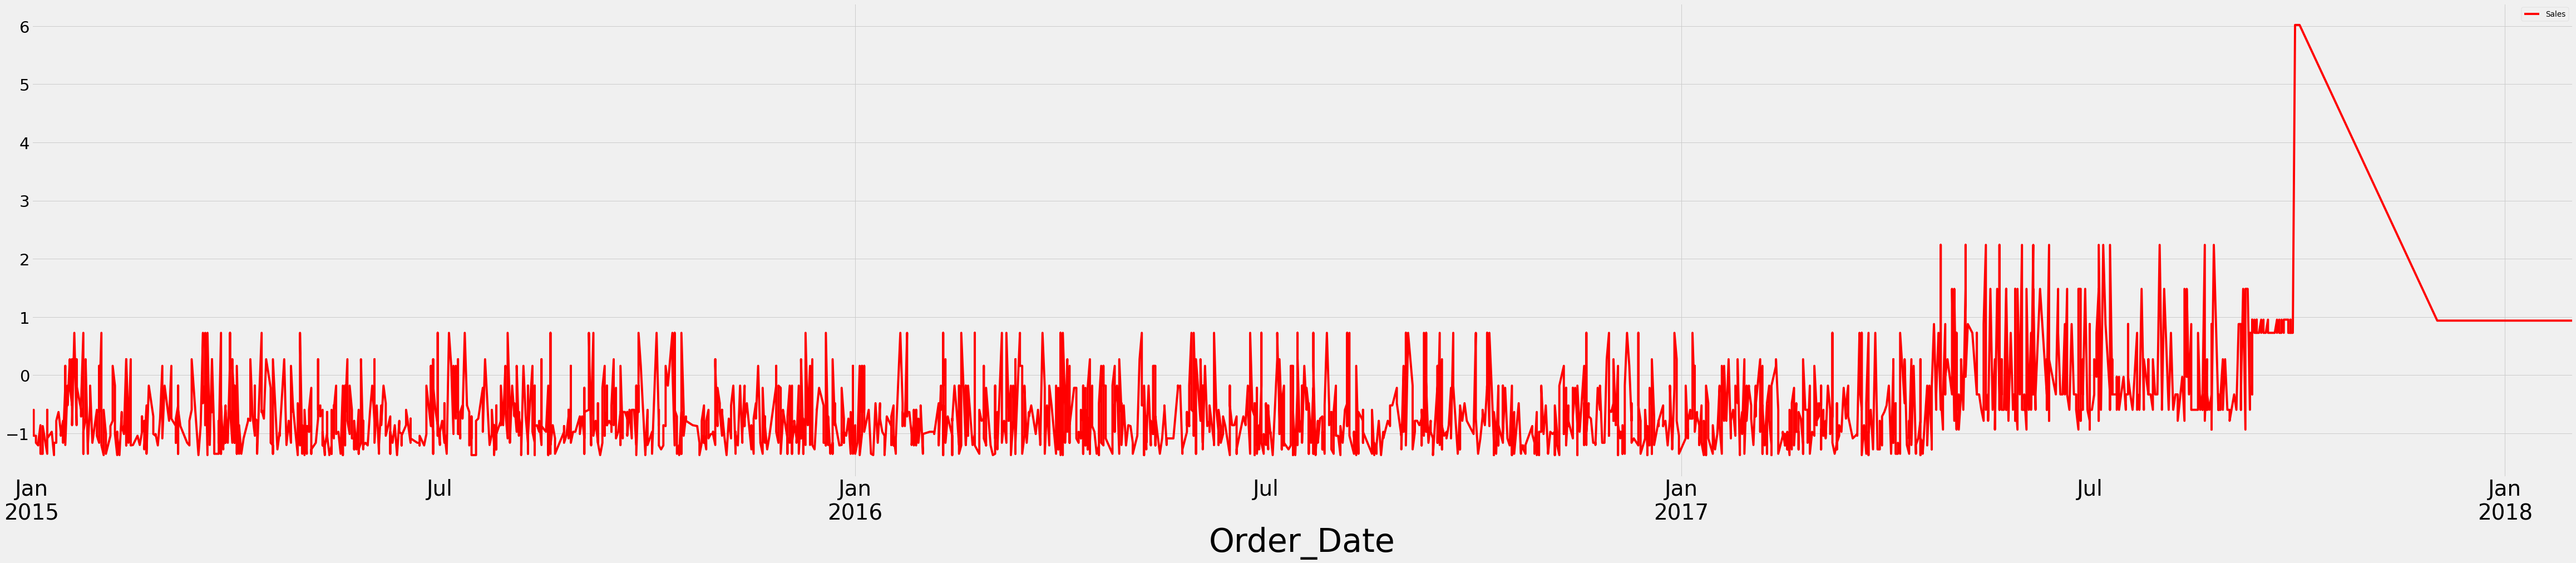

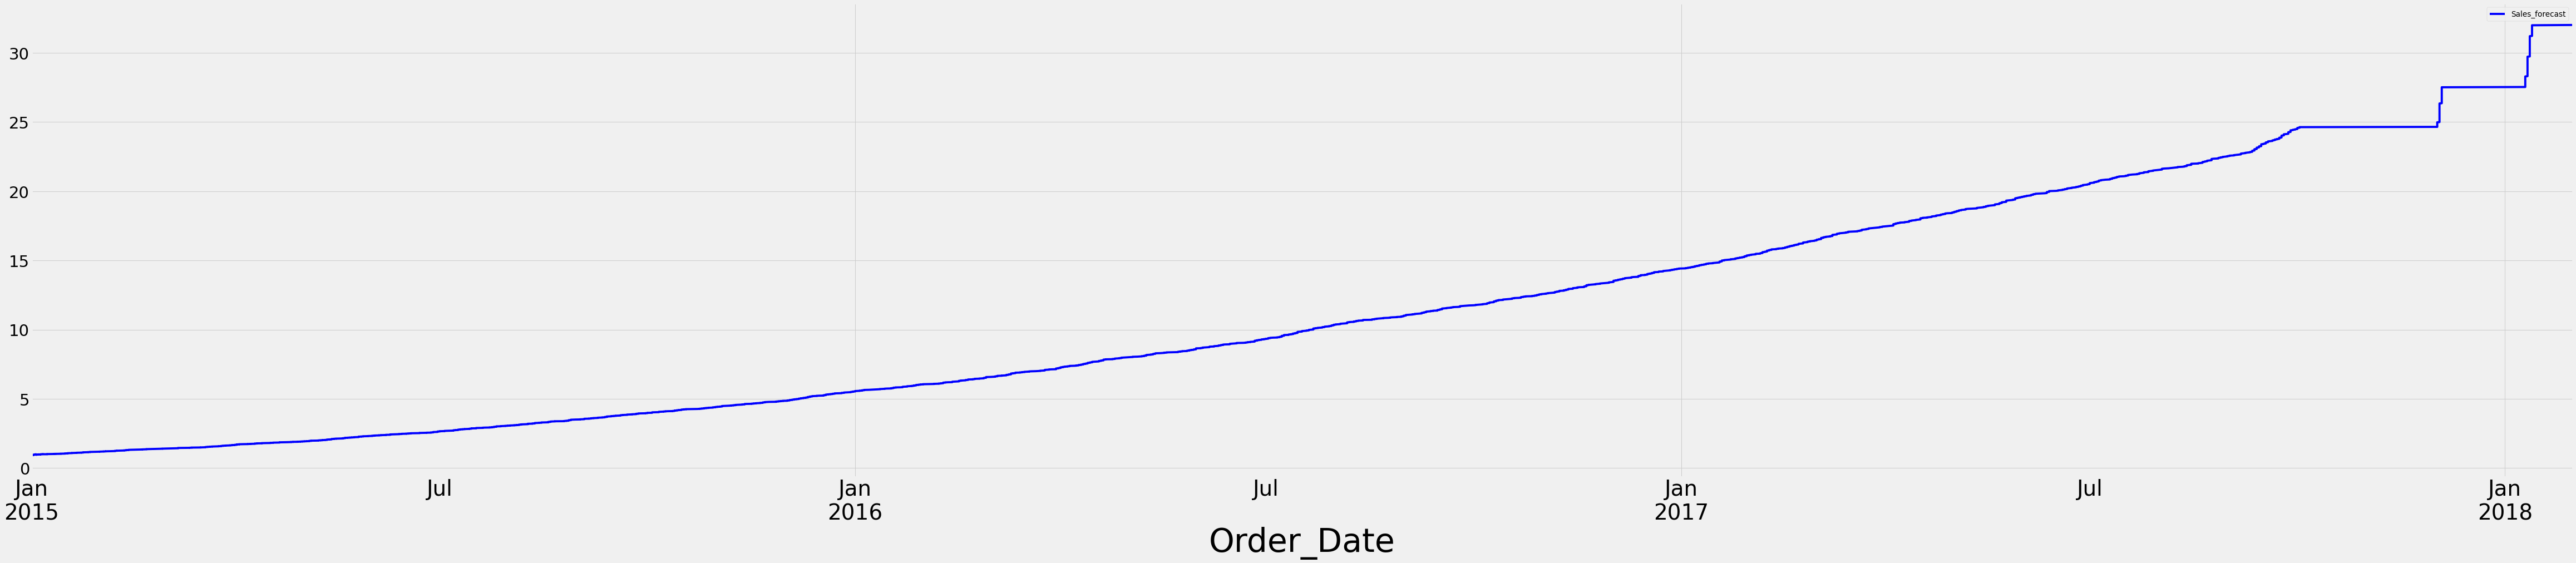

In [48]:
matplotlib.rcParams['axes.labelsize'] = 60
matplotlib.rcParams['xtick.labelsize'] = 40
matplotlib.rcParams['ytick.labelsize'] = 30
col='Sales'
plt.figure(figsize=(75,15), dpi=70)
ax = plt.gca()
unnorm.plot(kind='line',y=col, color='red', ax=ax)
plt.show()
plt.figure(figsize=(75,15), dpi=70)
ax = plt.gca()
df_results.plot(kind='line',y=col+"_forecast",color='blue',ax=ax,)
plt.show()